In [1]:
import numpy as np
import sympy as sp
import pandas as pd
import scipy.optimize as sco
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.layouts import gridplot
output_notebook()

Loading BokehJS ...

In [2]:
def finite_eq(xlin=50, tlin=1000, a=0, b=10, c=0, d=10, param=1):
    u = np.zeros((tlin+1, xlin+1))
    x = np.linspace(a, b, xlin+1)
    t = np.linspace(c, d, tlin+1)
    xstep = (b - a) / xlin
    tstep = (d - c) / tlin

    dbig = x ** 2 + 1
    alpha = tstep ** 2 / xstep ** 2 * ((x ** 2 + 1)  - param * tstep / 4)

    if alpha.max() <= 1:
         print('Схема устойчива')
    else:
        print(f'Схема не устойчива: alpha.max() = {alpha.max()}')

    # Начальные условия
    u[0] = x
    for j in range(1, xlin):
        u[1, j] = (u[0, j+1] + u[0, j-1]) / 2 + 2 * tstep

    # Граничные условия
    u[:, 0] = 0
    u[:, xlin] = 0

    for i in range(1, tlin):
        for j in range(1, xlin):
            u[i+1, j] = (2 + tstep ** 2 * param) * u[i, j] - u[i-1, j] \
            + alpha[j] * (u[i, j-1] - 2 * u[i, j] + u[i, j+1])

    return u

def find_approx(k, left_part):
    return (1 - 1 / 2 ** k) / (1 / 2 ** k - 1 / 4 ** k) - left_part

In [3]:
myxlin = 80
mytlin = 5000

uh1 = finite_eq(xlin=myxlin)
uh2 = finite_eq(xlin=int(myxlin/2))
uh3 = finite_eq(xlin=int(myxlin/4))

ut1 = finite_eq(tlin=mytlin)
ut2 = finite_eq(tlin=int(mytlin/2))
ut3 = finite_eq(tlin=int(mytlin/4))

Схема устойчива
Схема устойчива
Схема устойчива
Схема устойчива
Схема устойчива
Схема устойчива


In [4]:
ph = np.linalg.norm(uh1[:,::2]-uh2)/np.linalg.norm(uh2[:,::2]-uh3)
pt = np.linalg.norm(ut1[::2,:]-ut2)/np.linalg.norm(ut2[::2,:]-ut3)

kh = sco.bisect(find_approx, a=-5, b=10, args=(ph))
kt = sco.bisect(find_approx, a=-5, b=10, args=(pt))

print(f'Порядок аппроксимации: {kh ** 2 + kt ** 2}')

Порядок аппроксимации: 0.15127040998032712


Дано ДУ

$$
\frac{d^2u}{dt^2} = D(x)\frac{d^2u}{dx^2} + aU \\
D(x) = x^2 + 1 \\
0 \le x \le 10
$$

Замена дифференциального оператора $\frac{d^2u}{dt^2}$
$$\frac{d^2u}{dt^2} = u_j^{i-1} - 2u_j^i + u_j^{i+1}$$
Аналогично для $\frac{d^2u}{dx^2}$

Порядок аппроксимации $O(\tau^2)+O(h^2)$


$$u_j^{i+1} = (2 + \tau^2 a) u_j^i - u_j^{i-1} + D(x) \frac{\tau^2}{h^2} (u_{j-1}^i - 2u_j^i + u_{j+1}^i)$$


In [5]:
lamda, i, j, a, x, tau, h, gamma = sp.symbols('lamda i j a x tau h gamma')
def expr(i, j):
    return lamda ** j * sp.exp(sp.I*i*gamma)
left_expr = expr(i+1, j)
right_expr = (2 + tau ** 2 * a) * expr(i, j) - expr(i-1, j) + (x ** 2 + 1) * tau ** 2 / h ** 2 * (expr(i, j-1) - 2 * expr(i, j) + expr(i, j+1))
exp = left_expr - right_expr
exp = exp / expr(i, j)
ans = sp.solve(exp, lamda)

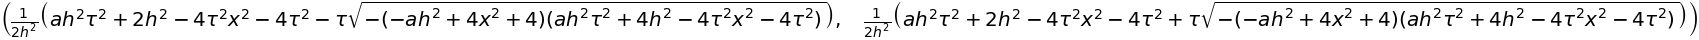

In [6]:
sp.init_printing()
D = lamda ** 2 + lamda * (4 * tau ** 2 / h ** 2 * (x ** 2 + 1) * sp.sin(gamma/2) ** 2 - a * tau ** 2 - 2) + 1
Ds = D.subs([(gamma, sp.pi)])
l1, l2 = sp.solve(Ds, lamda)
l1, l2

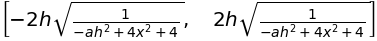

In [7]:
sp.solve(l1+1, tau)

In [8]:
plots = np.array([])
tlin = 1000
xlin = 50
for i in range(0, tlin+1, 28):
    p = figure(plot_width=150, plot_height=150, title=f'{i*10/tlin}')
    p.line(np.linspace(0, 10, xlin+1), ut1[i], line_width=1)
    plots = np.append(plots, [p])

pl = []
plots = plots.reshape(6, 6)
for i in plots:
    pl.append(i)

g = gridplot(pl)
show(g)